author: Gurjeet Singh (gurjeet.singh@helsinki.fi)

# Gaussian process regression

Having: 

$$ \mathbf{f} \sim \mathcal{N}(\mathbf{0}, \mathbf{K})$$
$$k(x, x') = \lambda \exp{\left(-\frac{1}{2l^2}(x-x')^2 \right)}$$
$$p(y \vert f(x) = \mathcal{N}(0, \sigma^2)$$

We want to retrieve a posterior distribution, by finding $\boldsymbol{\theta} = (\lambda, l, \sigma^2)$ hyperparameters such that it maximizes the marginal likelihood:
$$ p(y\vert f, x, \boldsymbol\theta) = \int_{\mathbf{\theta}} p(y \vert f,\boldsymbol{\theta}) \; p(\boldsymbol{\theta} \vert f) d\mathbf{\theta} $$

The marginal likelihood for GP can be computed in the following close form, using the log marginal likelihood:

$$ log p(\mathbf{y} \vert \mathbf{x}) = log \mathcal{N}(\mathbf{y} \vert 0, \mathbf{K} + \sigma^2 \mathbf{I}) = -0.5 \left( N log(2\pi) + log \vert K + \sigma^2 \mathbf{I}\vert + \mathbf{y}^{T} (\mathbf{K} + \sigma^2 \mathbf{I})^{-1}\mathbf{y}\right)$$

In our experiment we used a SGD optimizer to find the required hyperparameter such that maximize the log marginal likelihood.

In [72]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import numpy as np
import scipy.stats as stats
%matplotlib inline

In [73]:
data = np.genfromtxt("./problem1data.csv", delimiter=',')
data = data[data[:, 0].argsort()]

def cov_kernel(A, B, l=0.5, lamb=1):
    K = lamb*torch.exp(-1/(2*l**2) * (A[:,None ] - B[:, None].T)**2)
    return K

def neg_marginal_likelihood(y_obs, K, noise, N):
    K_noise = K + torch.eye(len(K)) * (noise**2.0)
    K_noise_inv = torch.linalg.inv(K_noise)
    return 0.5 * (N * torch.log(torch.tensor(2*np.pi)) + torch.log(torch.linalg.det(K_noise)) + y_obs.T @ K_noise_inv @ y_obs)

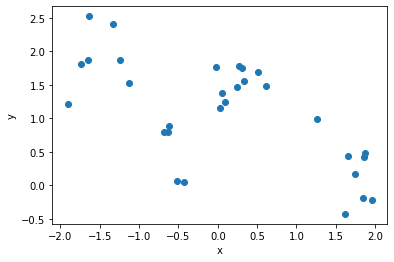

-1.9066457748413086 1.9598026275634766


In [74]:
X = torch.tensor(data[:, 0])
Y = torch.tensor(data[:, 1])
N = data.shape[0]

plt.scatter(data[:, 0], data[:, 1])
plt.xlabel('x')
plt.ylabel('y')
plt.show()
print(X.min().detach().numpy(), X.max().detach().numpy())

Prior variance \lambda: 1.5189891
Length scale: 0.6507974
Sigma-noise: 0.33112243


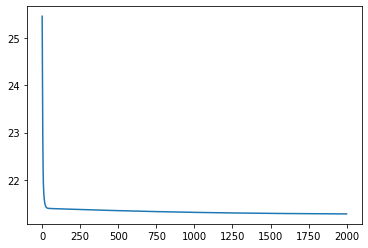

In [75]:
#Parameters
parameters = [(2, 1.5, 0.1), (0.1, 1.5, 0.2)] # Fixed Worse parameters
epochs = 2000
length_scale = torch.nn.Parameter(torch.tensor(0.5))
lamb = torch.nn.Parameter(torch.tensor(2.))
sigma = torch.nn.Parameter(torch.tensor(.5))

optimizer = torch.optim.SGD({length_scale, lamb, sigma}, lr=1e-3)

loss_values = torch.zeros(epochs)
for i in range(epochs):
    K = cov_kernel(X, X, length_scale, lamb)
    #K = K + torch.eye(len(K))*1e-7
    loss = neg_marginal_likelihood(Y, K, sigma, N)
    loss_values[i] = loss.clone()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    
parameters.append((length_scale.detach(), lamb.detach(), sigma.detach()))
plt.plot(np.arange(0, epochs), loss_values.detach().numpy())
print("Prior variance \lambda:", lamb.detach().numpy())
print("Length scale:", length_scale.detach().numpy())
print("Sigma-noise:", sigma.detach().numpy())

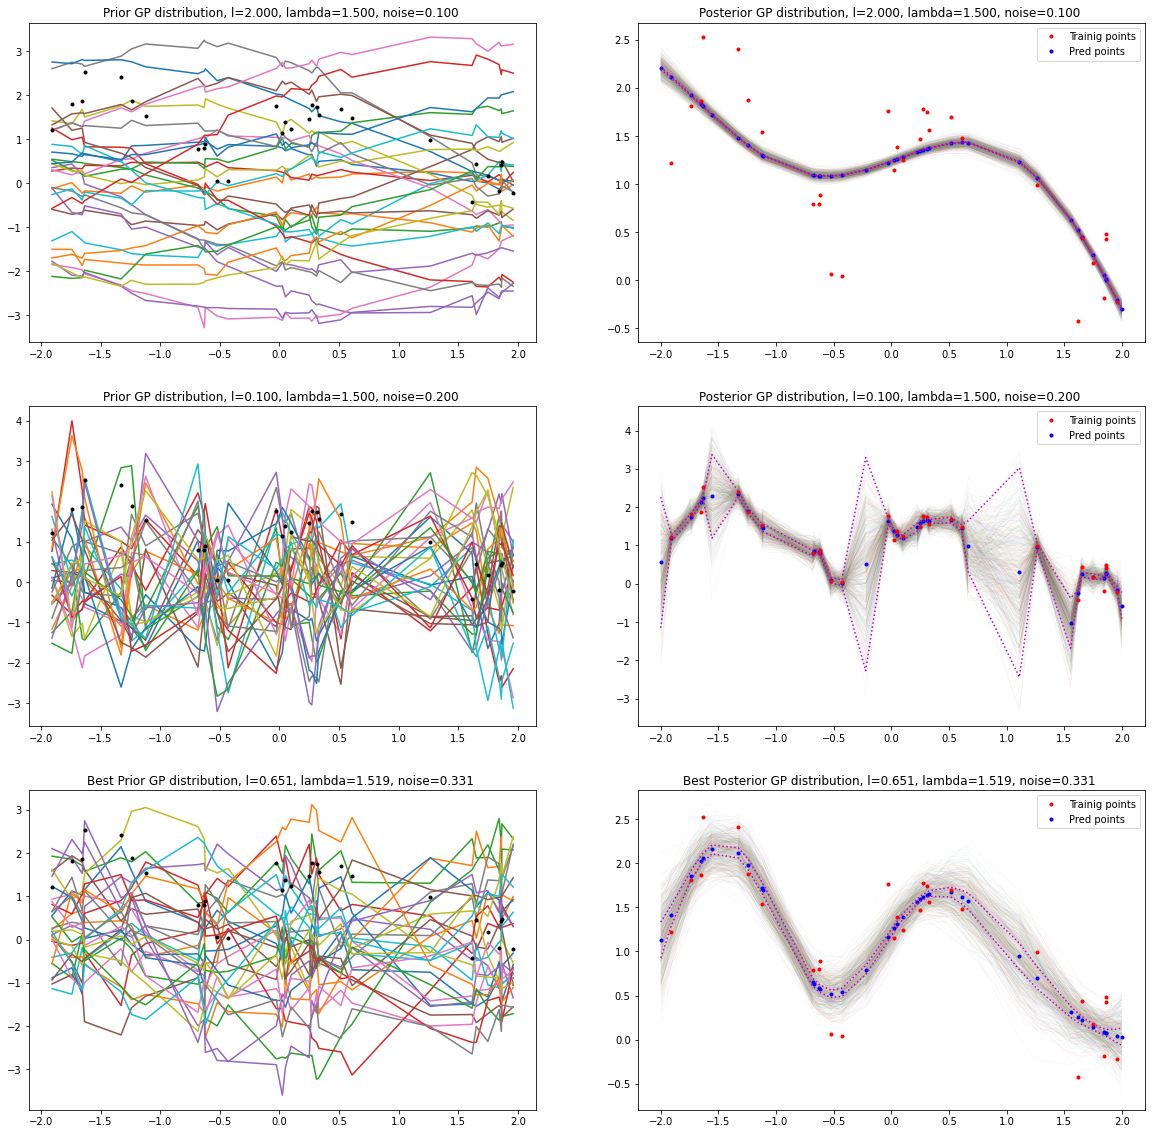

In [76]:
def posterior(y_obs, k_obs, k_pred, k_pred_obs):
    alpha = torch.matmul(k_pred_obs, torch.linalg.inv(k_obs))
    mu_pred = torch.matmul(alpha, y_obs)
    cov_pred = k_pred - torch.matmul(alpha, k_pred_obs.T)
    return mu_pred, cov_pred

RMSE = []
R_2 = []
fig, ax = plt.subplots(3, 2, figsize=(20,20))
i = 0
j = 0
for l, lam, s in parameters:
    #Prior GP
    K = cov_kernel(X, X, l, lam)
    K += torch.eye(len(K)) * (s**2.0)
    multN = torch.distributions.MultivariateNormal(torch.zeros(N).double(), K)
    for n in range(30):
        y_samples = multN.sample()
        ax[i, j].plot(X, y_samples)

    ax[i, j].plot(X, Y, 'k.')
    title = "Prior GP distribution, l={:.3f}, lambda={:.3f}, noise={:.3f} ".format(l, lam, s)
    if i == 2: 
        title = "Best " + title
    ax[i, j].set_title(title)
    j += 1

    #Posterior GP
    X_test = torch.linspace(-2, 2, 10)
    X_test, _ = torch.sort(torch.cat((X, X_test)))
    K_t = cov_kernel(X_test, X, l, lam)
    K_tt = cov_kernel(X_test, X_test, l, lam)
    K_tt = K_tt + torch.eye(len(K_tt))*1e-7

    post_mu, post_cov = posterior(Y, K, K_tt, K_t)

    X_test = X_test.detach()
    
    for n in range(500):
        y_pred = torch.distributions.MultivariateNormal(post_mu, post_cov).sample()
        ax[i, j].plot(X_test, y_pred.detach(), linewidth=0.15, alpha=0.2)

    pred_point,  = ax[i, j].plot(X_test, post_mu.detach(), 'b.', label='Pred points')
    tr_points, = ax[i, j].plot(X.detach(), Y.detach(), 'r.', label='Trainig points')
    ax[i, j].plot(X_test, (post_mu + 2*torch.diag(post_cov)).detach(), 'm:')
    ax[i, j].plot(X_test, (post_mu - 2*torch.diag(post_cov)).detach(), 'm:')
    
    title = "Posterior GP distribution, l={:.3f}, lambda={:.3f}, noise={:.3f} ".format(l, lam, s)
    if i == 2: 
        title = "Best " + title
    ax[i, j].set_title(title)
    ax[i, j].legend(handles=[tr_points, pred_point])
    
    
    RMSE.append(((((post_mu[torch.searchsorted(X_test, X)] - Y)**2).sum())/len(Y)).sqrt())
    R_2.append(1. - ((post_mu[torch.searchsorted(X_test, X)] - Y)**2).sum()/((Y.mean() - Y)**2).sum())
    
    i+=1
    j=0

In [77]:
print("Training RMSE: ")
RMSE = torch.tensor(RMSE).numpy()
for i in range(len(RMSE)):
    print(" Model {:d}: {:.2f}".format( i+1, RMSE[i]))

Training RMSE: 
 Model 1: 0.48
 Model 2: 0.14
 Model 3: 0.29


As our experiment shows the GP model with parameters $l=0.651, \lambda=1.519, \sigma=0.331$ retrieved from the MLE gradient based optimization, is able to efficiently model the data.

In the previous figure we see three examples of GP model. For each model we show the prior distribution and the posterior on the fitted data and some generated data in the range of $[-2, 2)$. The red dotted data are the true labels instead the blue are the prediction including those for the generated data.<br/>
We show three different examples of GP models, the first two are defined by manually assigning their hyperparameters. The first one is made by a smoother kernel ($l=2$) than the other models, and it has a low noise value. This model, results in biases issues with a high RMSE value. It is not able to properly fit the data and it takes in consideration just a low variance of noise, .<br/>
In the second GP model, we see a clear example of overfitting issue, the training RMSE is very low and from the graph we see that the model present a high variance, since it interpolates each single traning points. In addition we can see that in the generated points, in particular those which are far away from the training points, the model present a very high variance ending up with high C.I of the predictive mean.<br/>
By selecting these models, we wanted to emphasize the impact of the length scale. Indeed by assigning a small length-scale ($l=0.1$) in the kernel function (as in the second example), the pior distribution results in a high trending behaviour in the functions.<br/>
Finally in the last example the we show the best model using the estimated hypeparameter retrieved by the gradient optimization problem. In this case we have a lower RMSE error than the first example and the model is able to generalize better its prediction on the generated data. Indeed, we end up with more smooth functions, and we see that there are just a few training points that lie outside from the CI and some of them (e.g the first two) are captured from the posteriors samples functions.

# Non Conjugate GP

Having:

$$ p(y \vert f) = Poisson(e^f) $$
$$ f \sim \mathcal{N}(\mathbf{0}, \mathbf{K}) $$
$$k(x, x') = \lambda \exp{\left(-\frac{1}{2l^2}(x-x')^2 \right), \quad  \lambda=2 \;\; l=2} $$
 
We want to find the optimal mean latent function of the Laplace approximation method such that we maximize the joint log-likelihood between the poisson distirbution and the prior normal disitribution, by using a gradient optimization algorithm.

Thus

$$
\begin{aligned}
\mathcal{L} &=\sum_{i=1}^{n}\left(\log p\left(y_{n} \mid f_{n}\right)\right)+\log p(\boldsymbol{f} \mid x)=\\
&=\sum_{i=1}^{n}\left(\log p\left(y_{n} \mid f_{n}\right)\right)-\frac{N}{2} \log (2 \pi)+\log |\mathbf{K}|-\frac{1}{2} \boldsymbol{f}^{\top} \mathbf{K}^{-1} \boldsymbol{f} \\
&=\sum_{i=1}^{n}\left(-e^{f_n}+ y_{n} \hat{f}_{n}+C_1\right)-\frac{N}{2} \log (2 \pi)+\log |\mathbf{K}|-\frac{1}{2} \boldsymbol{f}^{\top} \mathbf{K}^{-1} \boldsymbol{f}\\
&=\sum_{i=1}^{n}\left(y_{n} \hat{f}_{n}\left(x_{n}\right)-e^{\hat{f}_{n}}+C_{1}\right)-\frac{1}{2} f^{\top} \mathbf{K}^{-1} f + C_{2}
\end{aligned}
$$

$$ \boldsymbol{\hat{f}} = argmax_{\hat{f}} \; \sum_{i=1}^{n}\left(y_{n} \hat{f}_{n}\left(x_{n}\right)-e^{\hat{f}_{n}}+C_{1}\right)-\frac{1}{2} f^{\top} \mathbf{K}^{-1} f + C_{2}$$

Therefore, we need the gradient for the updating rule in order to find the optimal function
$$
\nabla_{\hat{f}} \mathcal{L} = \sum_{i=1}^{n}\left(y_{n}  - e^{\hat{f}_{n}}\right)- \mathbf{K}^{-1} f.
$$
And lately its hessian for the Laplace approximation method
$$
\begin{aligned}
\nabla_{\hat{f}}^2 \mathcal{L} &=  - \sum_{i=1}^{n}\left(e^{\hat{f}_{n}}\right)- \mathbf{K}^{-1}\\
&= - diag\left(e^{\hat{f}_{n}}\right) - \mathbf{K^{-1}}\\
&= - \mathbf{W} - \mathbf{K^{-1}}.
\end{aligned}
$$

Thus the latent distribution retrieved by the Laplace approximation method is distributed as:

$$ \boldsymbol{f^*} \sim \mathcal{N\left(\boldsymbol{\hat{f}},\;  \left(\mathbf{W} + \mathbf{K^{-1}}\right)^{-1} \right)}$$

Finally, we plug in some samples from the latent distribution to the Poisson distribution and sample from the latter one.

$$ \boldsymbol{y} \sim Poisson(e^{\boldsymbol{f^*}}) $$

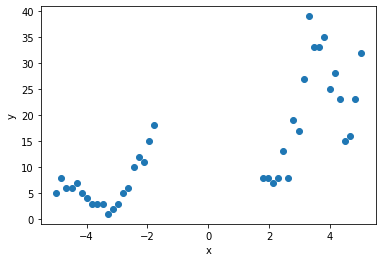

In [78]:
data = np.genfromtxt("./problem2data.csv", delimiter=',')
data = data[data[:, 0].argsort()]

plt.scatter(data[:, 0], data[:, 1])
plt.xlabel('x')
plt.ylabel('y')
plt.show()


In [79]:
l=0.5; lamb = 2.0

def neg_joint_likelihood(y, f, K):
    quad_term =  0.5 * f.T @ torch.linalg.inv(K) @ f
    return -(torch.sum( f * y  - torch.exp(f)) - quad_term)

Mean X: 0.0


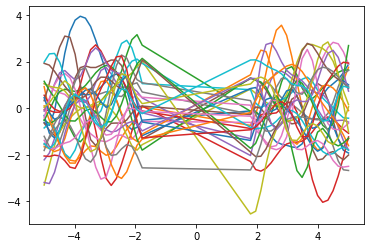

In [80]:
X = torch.tensor(data[:, 0])
Y = torch.tensor(data[:, 1])
K = cov_kernel(X, X, l, lamb)
K = K + torch.eye(len(K)) * 1e-7
print('Mean X:', X.mean().numpy()) #Data already centered
prior_dist = torch.distributions.MultivariateNormal(torch.zeros(len(K)).double(), K)
fig, ax = plt.subplots()
for n in range(30):
    y_samples = prior_dist.sample()
    ax.plot(X, y_samples)
plt.show()

tensor(3749278.2500)
tensor(-71.5963)
Parameter containing:
tensor([0.2391, 0.7388, 0.8101, 0.6586, 0.5282, 0.5009, 0.5701, 0.7060, 0.7796,
        0.6397, 0.3741, 0.2688, 0.3892, 0.4730, 0.3782, 0.3137, 0.4151, 0.4599,
        0.3530, 0.6163, 0.3817, 1.0608, 0.7438, 0.3717, 0.4063, 0.6376, 0.7803,
        0.8372, 0.8629, 0.7892, 0.6301, 0.5452, 0.5550, 0.4809, 0.2925, 0.2087,
        0.3057, 0.3635, 0.3459, 0.7422], dtype=torch.float64,
       requires_grad=True)


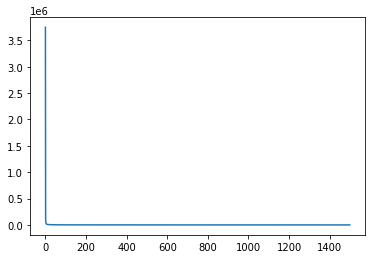

In [81]:
#f_n = prior_dist.sample()
f_n = torch.rand(len(X)).double()
epochs = 1500
param_fn = torch.nn.Parameter(f_n)
optimizer = torch.optim.SGD({param_fn}, lr=1e-7)
loss_values = torch.zeros(epochs)
for i in range(epochs):
    loss = neg_joint_likelihood(Y, param_fn, K)
    loss_values[i] = loss.clone().detach()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
plt.plot(np.arange(0, epochs), loss_values)
print(loss_values[0])
print(loss_values[-1])
print(param_fn)

We first tried the SGD by taking a sample from the prior distribution as initial point for the gradient based optimization, but the minimization of the loss worked better with some random initialization for the initial starting point. In addition the SGD required a very low learning rate $1e{-7}$ otherwise the loss get very high during the optimization problem and causing infinity values and later nan value for the gradient, i.e gradient exploding issue. <br/>
A better option could be the IRLS method, as suggested in the Murphy's book at section 15.3.1.1, but we can also exploit a quasi newton method called BFGS explained in section 8.3.5 from the same book, just after the IRLS method. Indeed for this latter method pytorch makes avvailable an optimizer called LBFGS, which is an extension of BFGS.<br/>
In our experiment, this last optimizer achieved better result in less iteration than SGD, especially by starting the optimization from a  sample from the prior distribution as the initial starting point.

In [82]:
f_n = prior_dist.sample()
epochs = 100
param_fn = torch.nn.Parameter(f_n)
optimizer = torch.optim.LBFGS([param_fn])
loss_values = torch.zeros(epochs)
for i in range(epochs):
    def closure():
        loss = neg_joint_likelihood(Y, param_fn, K)
        optimizer.zero_grad()
        loss.backward()
        loss_values[i] = loss.clone().detach()
        return loss
    optimizer.step(closure)

tensor(-10.0479)
tensor(-1029.9508)
Parameter containing:
tensor([1.6558, 1.8464, 1.9143, 1.8776, 1.7686, 1.6117, 1.4158, 1.1856, 0.9445,
        0.7495, 0.6803, 0.7969, 1.0938, 1.4896, 1.8736, 2.1746, 2.3942, 2.5715,
        2.7144, 2.7666, 1.9388, 2.0374, 2.0927, 2.1540, 2.2605, 2.4408, 2.7053,
        3.0234, 3.3182, 3.5077, 3.5658, 3.5347, 3.4681, 3.3695, 3.2081, 3.0013,
        2.8556, 2.8930, 3.1189, 3.3733], dtype=torch.float64,
       requires_grad=True)


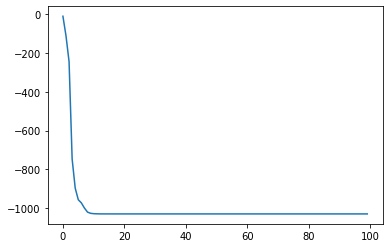

In [83]:
plt.plot(np.arange(0, epochs), loss_values)
print(loss_values[0])
print(loss_values[-1])
print(param_fn)

In [84]:
neg_hessian = torch.eye(len(f_n)) * (torch.exp(f_n)) + torch.linalg.inv(K)
# Laplace method - Normal Distribution
post_cov = torch.linalg.inv(neg_hessian)
latent_dist = torch.distributions.MultivariateNormal(f_n, post_cov)

In [1]:
Npred = 100
xpred = torch.linspace(-5, 5, Npred)

NameError: name 'torch' is not defined

In [85]:
samples = latent_dist.sample((5000,))
q =  torch.tensor([0.25, 0.75], dtype=torch.float64)
quantiles = torch.quantile(samples, q , dim=0)

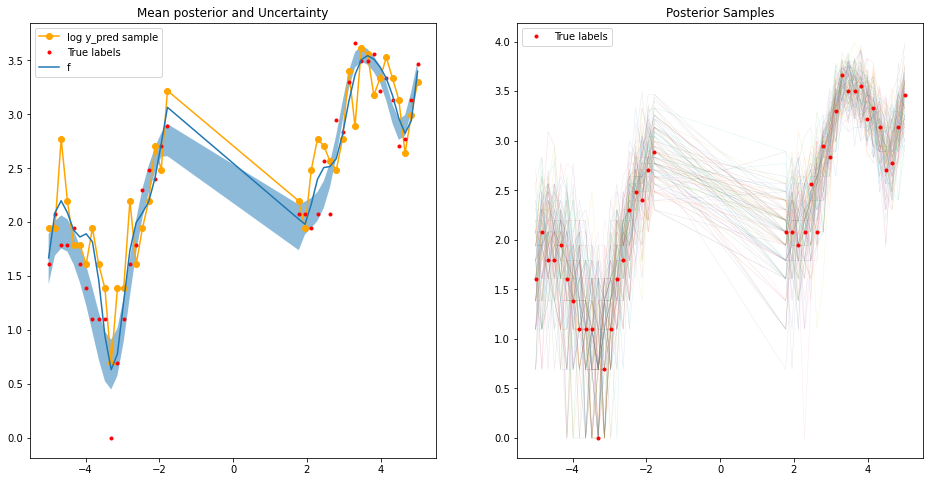

In [92]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
f_sample = latent_dist.sample()
y_pred_dist = torch.distributions.Poisson(torch.exp(f_sample))
ax[0].plot(X, torch.log(y_pred_dist.sample()+1), 'o-', color='orange',label=f'log y_pred sample')

ax[0].plot(X, torch.log(Y), 'r.', label='True labels')
ax[0].plot(X, f_sample, label='f')

uncertainty = 1.96 * torch.diag(post_cov)
#ax[0].fill_between(X, f_sample + uncertainty,  f_sample - uncertainty, alpha=0.5)
ax[0].fill_between(X, quantiles[0, :],  quantiles[1, :], alpha=0.5)
ax[0].legend()
ax[0].set_title('Mean posterior and Uncertainty')

n_samples = 100
RMSE = torch.zeros(n_samples)
for i in range(0, n_samples):
    f_sample = latent_dist.sample()
    y_pred_dist = torch.distributions.Poisson(torch.exp(f_sample))
    y_pred = y_pred_dist.sample()
    ax[1].plot(X, torch.log(y_pred+1), '-', linewidth=0.5, alpha=0.15)
    RMSE[i] = (((((y_pred - Y)**2).sum())/len(Y)).sqrt())
    
ax[1].plot(X, torch.log(Y), 'r.', label='True labels')

ax[1].set_title('Posterior Samples')
ax[1].legend()
plt.show()

In [93]:
print("Mean sample RMSE", RMSE.mean().numpy())

Mean sample RMSE 4.736485


The uncertainty is obtained with a frequentist approach, i. e by sampling from the posteriori distribution, like 5000 times and then we considered the first and the third quantile of the values.
It can be seen that where the training data points are denser, the uncertainty of the model prediction tends to be lower, and where the training data points are sparse, the model prediction uncertainty is higher.

Overall the model is able to predict and describe the data, indeed the RMSE obtained is small.